# Bay Area Bike Share Analysis

## Introduction

> **Tip**: Quoted sections like this will provide helpful instructions on how to navigate and use an iPython notebook.

[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.

In this project, you will put yourself in the shoes of a data analyst performing an exploratory analysis on the data. You will take a look at two of the major parts of the data analysis process: data wrangling and exploratory data analysis. But before you even start looking at data, think about some questions you might want to understand about the bike share data. Consider, for example, if you were working for Bay Area Bike Share: what kinds of information would you want to know about in order to make smarter business decisions? Or you might think about if you were a user of the bike share service. What factors might influence how you would want to use the service?

**Question 1**: Are there more number of Subscribers or customers?

**Answer**:There are more number of subscribers !



## Using Visualizations to Communicate Findings in Data



**Question 2**: Who uses the Bay Area Bike Share and Rides by duration break down by subscription type are the interesting visualisations I found? why? why not?

**Answer**: Subscribers contrubite more number of trips and rides by duration broken down on subscription type cannot be found using usage stas and usage plots kind of visualiastions but they can be ana;ysed using numpy and pandas.

## Data Wrangling

Now it's time to explore the data for yourself. Year 1 and Year 2 data from the Bay Area Bike Share's [Open Data](http://www.bayareabikeshare.com/open-data) page have already been provided with the project materials; you don't need to download anything extra. The data comes in three parts: the first half of Year 1 (files starting `201402`), the second half of Year 1 (files starting `201408`), and all of Year 2 (files starting `201508`). There are three main datafiles associated with each part: trip data showing information about each trip taken in the system (`*_trip_data.csv`), information about the stations in the system (`*_station_data.csv`), and daily weather data for each city in the system (`*_weather_data.csv`).

When dealing with a lot of data, it can be useful to start by working with only a sample of the data. This way, it will be much easier to check that our data wrangling steps are working since our code will take less time to complete. Once we are satisfied with the way things are working, we can then set things up to work on the dataset as a whole.

Since the bulk of the data is contained in the trip information, we should target looking at a subset of the trip data to help us get our bearings. You'll start by looking at only the first month of the bike trip data, from 2013-08-29 to 2013-09-30. The code below will take the data from the first half of the first year, then write the first month's worth of data to an output file. This code exploits the fact that the data is sorted by date (though it should be noted that the first two days are sorted by trip time, rather than being completely chronological).

First, load all of the packages and functions that you'll be using in your analysis by running the first code cell below. Then, run the second code cell to read a subset of the first trip data file, and write a new file containing just the subset we are initially interested in.



In [1]:
# import all necessary packages and functions.
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [2]:
# file locations
file_in  = '201402_trip_data.csv'
file_out = '201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # set up csv reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader)
        # trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

The first step is to look at the structure of the dataset to see if there's any data wrangling we should perform. The below cell will read in the sampled data file that you created in the previous cell, and print out the first few rows of the table.

In [3]:
sample_data = pd.read_csv('201309_trip_data.csv')

display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In this exploration, we're going to concentrate on factors in the trip data that affect the number of trips that are taken. Let's focus down on a few selected columns: the trip duration, start time, start terminal, end terminal, and subscription type. Start time will be divided into year, month, and hour components. We will also add a column for the day of the week and abstract the start and end terminal to be the start and end _city_.

Let's tackle the lattermost part of the wrangling process first. Run the below code cell to see how the station information is structured, then observe how the code will create the station-city mapping. Note that the station mapping is set up as a function, `create_station_mapping()`. Since it is possible that more stations are added or dropped over time, this function will allow us to combine the station information across all three parts of our data when we are ready to explore everything.

In [4]:
# Display the first few rows of the station data file.
station_info = pd.read_csv('201402_station_data.csv')
display(station_info.head())

# This function will be called by another function later on to create the mapping.
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's
            # dictionary keys
            station_reader = csv.DictReader(f_in)

            for row in station_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [5]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments will be lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    ### Question 3a: Add a mathematical operation below   ###
                    ### to convert durations from seconds to minutes.     ###
                    new_point['duration'] = float(row['Duration']) / 60
                    
                    # reformat datestrings into multiple columns
                    ### Question 3b: Fill in the blanks below to generate ###
                    ### the expected time values.                         ###
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%B')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%A')
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point)

In [6]:
# Process the data by running the function we wrote above.
station_data = ['201402_station_data.csv']
trip_in = ['201309_trip_data.csv']
trip_out = '201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# Load in the data file and print out the first few rows
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

# Verify the dataframe by counting data points matching each of the time features.
question_3(sample_data)

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,August,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,August,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,August,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,August,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,August,12,Thursday,San Francisco,San Francisco,Subscriber


All counts are as expected!




## Exploratory Data Analysis



In [7]:
trip_data = pd.read_csv('201309_trip_summary.csv')

usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

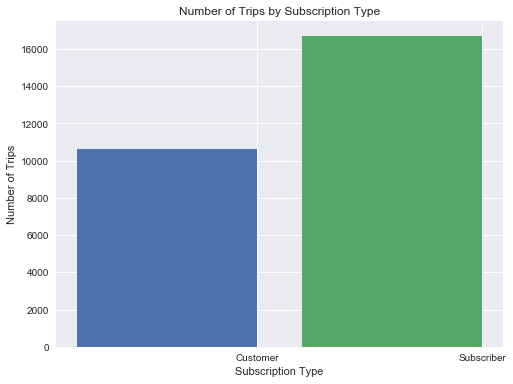

In [8]:
usage_plot(trip_data, 'subscription_type')

Seems like there's about 50% more trips made by subscribers in the first month than customers. Let's try a different variable now. What does the distribution of trip durations look like?

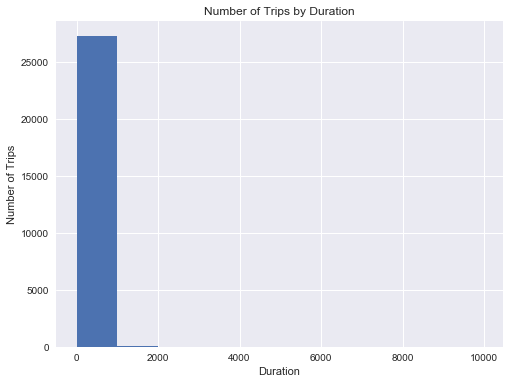

In [9]:
usage_plot(trip_data, 'duration')

Looks pretty strange, doesn't it? Take a look at the duration values on the x-axis. Most rides are expected to be 30 minutes or less, since there are overage charges for taking extra time in a single trip. The first bar spans durations up to about 1000 minutes, or over 16 hours. Based on the statistics we got out of `usage_stats()`, we should have expected some trips with very long durations that bring the average to be so much higher than the median: the plot shows this in a dramatic, but unhelpful way.

When exploring the data, you will often need to work with visualization function parameters in order to make the data easier to understand. Here's where the third argument of the `usage_plot()` function comes in. Filters can be set for data points as a list of conditions. Let's start by limiting things to trips of less than 60 minutes.

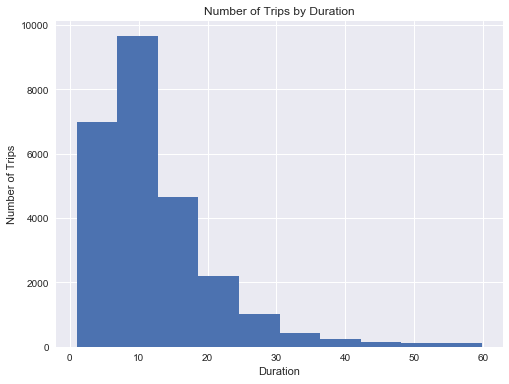

In [10]:
usage_plot(trip_data, 'duration', ['duration < 60'])

This is looking better! You can see that most trips are indeed less than 30 minutes in length, but there's more that you can do to improve the presentation. Since the minimum duration is not 0, the left hand bar is slighly above 0. We want to be able to tell where there is a clear boundary at 30 minutes, so it will look nicer if we have bin sizes and bin boundaries that correspond to some number of minutes. Fortunately, you can use the optional "boundary" and "bin_width" parameters to adjust the plot. By setting "boundary" to 0, one of the bin edges (in this case the left-most bin) will start at 0 rather than the minimum trip duration. And by setting "bin_width" to 5, each bar will count up data points in five-minute intervals.

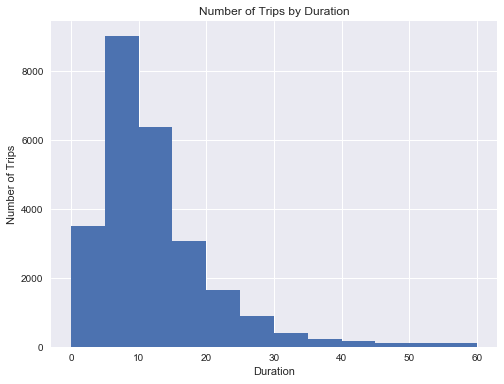

In [11]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

**Question 4**: Which five-minute trip duration shows the most number of trips? Approximately how many trips were made in this range?

**Answer**: Its 5-10 and and there are more than 8500 trips in this range




## Performing Your Own Analysis

Now that you've done some exploration on a small sample of the dataset, it's time to go ahead and put together all of the data in a single file and see what trends you can find. The code below will use the same `summarise_data()` function as before to process data.

In [12]:
station_data = ['201402_station_data.csv',
                '201408_station_data.csv',
                '201508_station_data.csv' ]
trip_in = ['201402_trip_data.csv',
           '201408_trip_data.csv',
           '201508_trip_data.csv' ]
trip_out = 'babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

In [13]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,August,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,August,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,August,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,August,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,August,12,Thursday,San Francisco,San Francisco,Subscriber


In [14]:
usage_stats(trip_data)

There are 669959 data points in the dataset.
The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


array([  5.73333333,   8.61666667,  12.58333333])

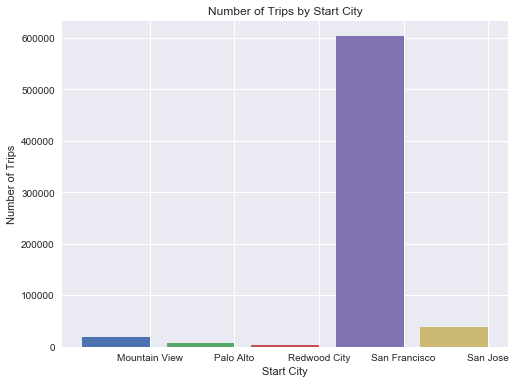

In [16]:

usage_plot(trip_data,"start_city")

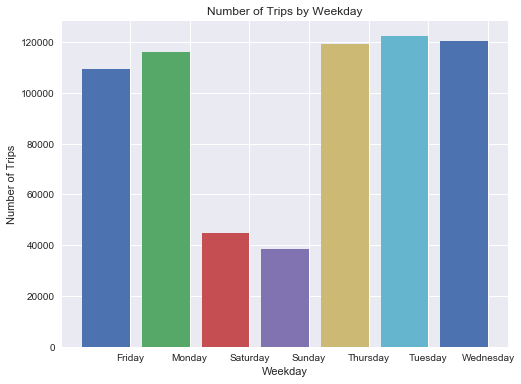

In [17]:
# Final Plot 1
usage_plot(trip_data,"weekday")

**Question 5a**: What is interesting about the above visualization? Why did you select it?

**Answer**: And the Visualisation shows that Tuesday is the poular day of the week!

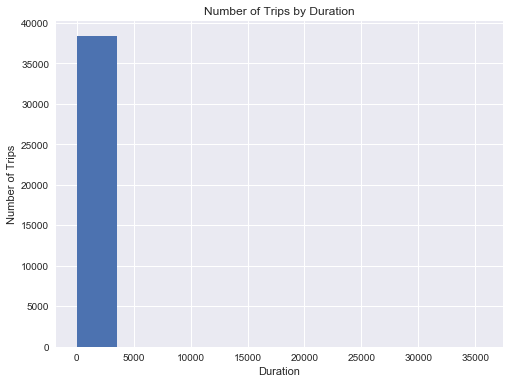

In [18]:
# Final Plot 2
usage_plot(trip_data,'duration',["weekday == 'Sunday'"])

**Question 5b**: What is interesting about the above visualization? Why did you select it?

**Answer**: And the Visualisattion shows that all tyhe trips contibute mote than 2000 minuetes on Sunday!

## Conclusions



As a Data Analyst I know the importance of how crucial it is to give valuable suggestions and intersting facts about the data.I would apply the concepts of data science to improve a company's sales and revenue..